In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Import our custom preprocessor
import preprocessor

In [3]:
# --- Parameters ---
TICKER = "AAPL"
SEQUENCE_LENGTH = 60

# --- Fetch and Process ---
try:
    # Use our preprocessor to get data with technical indicators
    raw_data = preprocessor.fetch_data(TICKER)
    processed_data = preprocessor.add_technical_indicators(raw_data.copy())
    
    print("\n--- Processed Data with Indicators ---")
    print(processed_data.head())
    
    # Keep a copy of the dates for plotting later
    dates = processed_data.index

except ValueError as e:
    print(e)

Fetching 5y of historical data for AAPL...
Adding technical indicators...

--- Processed Data with Indicators ---
                                 Open        High         Low       Close  \
Date                                                                        
2020-11-16 00:00:00-05:00  115.875155  117.892154  115.124873  117.219826   
2020-11-17 00:00:00-05:00  116.489060  117.580379  115.914162  116.333153   
2020-11-18 00:00:00-05:00  115.573101  116.752119  114.978719  115.007950   
2020-11-19 00:00:00-05:00  114.579222  116.011585  113.819194  115.602341   
2020-11-20 00:00:00-05:00  115.602327  115.728996  114.286894  114.335609   

                             Volume  Dividends  Stock Splits      SMA_20  \
Date                                                                       
2020-11-16 00:00:00-05:00  91183000        0.0           0.0  112.643669   
2020-11-17 00:00:00-05:00  74271000        0.0           0.0  112.745123   
2020-11-18 00:00:00-05:00  76322100       

In [4]:
# --- Scale the Data ---
# LSTMs work best with normalized data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(processed_data)

# --- Create Sequences ---
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data)):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(scaled_data[i, processed_data.columns.get_loc('Close')]) # Target is the 'Close' price

X, y = np.array(X), np.array(y)

print("\n--- Shape of the training data ---")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


--- Shape of the training data ---
X shape: (1146, 60, 17)
y shape: (1146,)


In [7]:
# --- Build the LSTM Model ---
model = Sequential([
    tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),

    # Input layer shape: (60 time steps, number of features)
    LSTM(units=50, return_sequences=True),
    Dropout(0.3),
    
    LSTM(units=50, return_sequences=False),
    Dropout(0.3),
    
    Dense(units=25),
    Dense(units=1) # Output layer: predicts a single value (the next 'Close' price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model architecture
model.summary()

# --- Train the Model ---
print("\n--- Training the model... ---")
# We'll use a portion of the data for validation to monitor for overfitting
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)
print("--- Model training complete. ---")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 13/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 14/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 15/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 16/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 17/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 18/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 19/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 20/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 21/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 22/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 23/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023

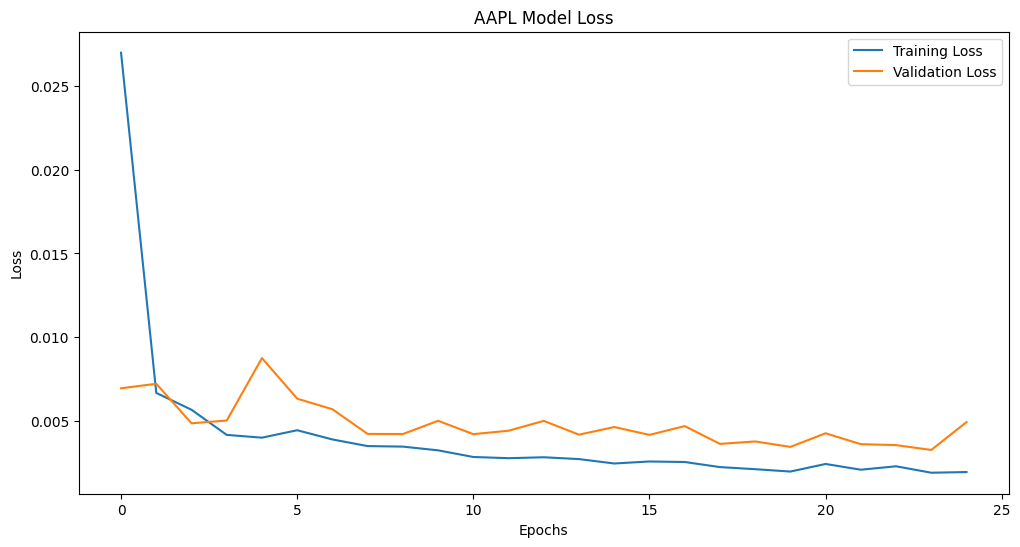

In [8]:
# --- Plot Training & Validation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{TICKER} Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# --- Make Predictions ---
print("--- Generating predictions... ---")
predicted_prices_scaled = model.predict(X)

# We need to reshape the predictions and the original y values to inverse transform them
# Create a dummy array with the same number of features as the original scaler
dummy_array = np.zeros((len(predicted_prices_scaled), X.shape[2]))
# Place our scaled predictions into the 'Close' price column (index determined earlier)
close_col_index = processed_data.columns.get_loc('Close')
dummy_array[:, close_col_index] = predicted_prices_scaled.flatten()

# Inverse transform to get the actual dollar values
predicted_prices = scaler.inverse_transform(dummy_array)[:, close_col_index]

# Also, inverse transform the original target values (y) for comparison
dummy_array_y = np.zeros((len(y), X.shape[2]))
dummy_array_y[:, close_col_index] = y.flatten()
actual_prices = scaler.inverse_transform(dummy_array_y)[:, close_col_index]

print("--- Prediction generation complete. ---")

--- Generating predictions... ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
--- Prediction generation complete. ---


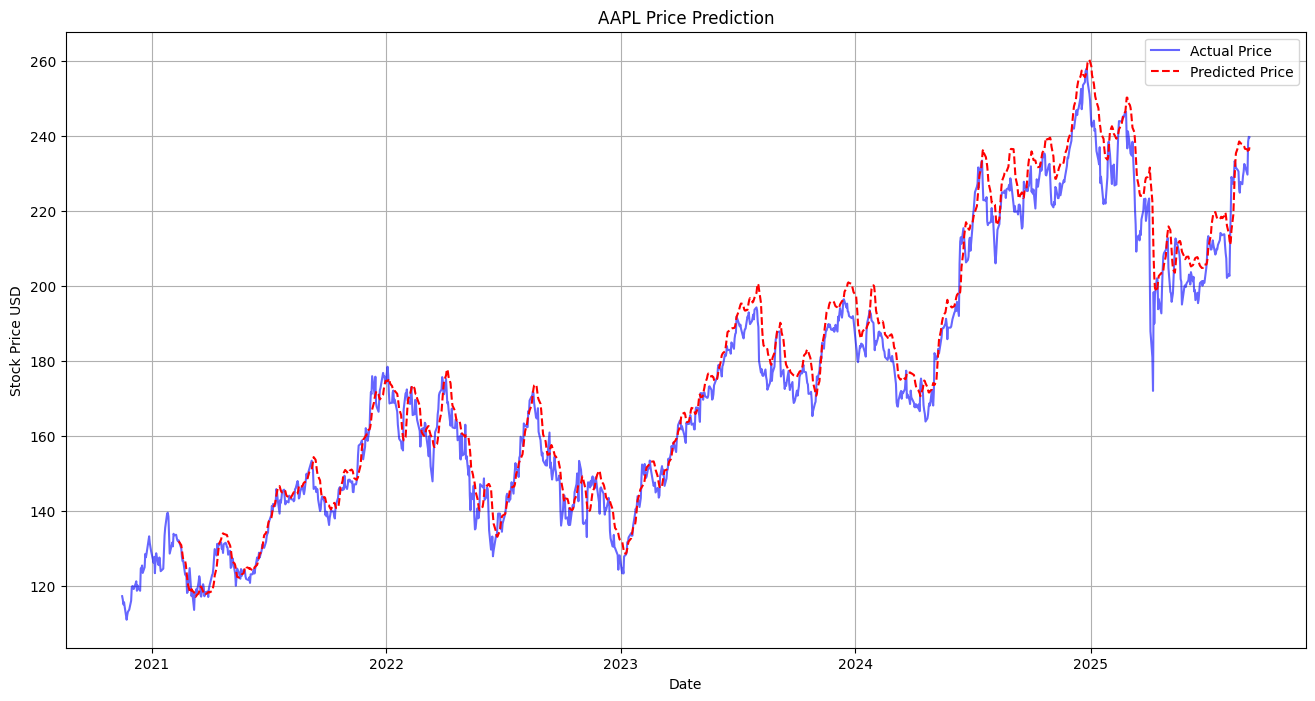

In [10]:
# --- Plot Actual vs. Predicted Prices ---
plt.figure(figsize=(16, 8))
plt.title(f'{TICKER} Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price USD')

# We need to plot against the correct dates, so we'll skip the first 60 days
# that were used for the initial sequence creation.
plt.plot(dates, processed_data['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(dates[SEQUENCE_LENGTH:], predicted_prices, label='Predicted Price', color='red', linestyle='--')

plt.legend()
plt.grid(True)
plt.show()

In [11]:
# --- Save the Model and Scaler ---
# We need to save both the model and the scaler to make future predictions
model_filename = f"{TICKER}_lstm_model.keras"
model_path = f"saved_models/{model_filename}"

print(f"\n--- Saving model to {model_path} ---")
model.save(model_path)

# It's also crucial to save the scaler, as we'll need it to process
# new data in the same way before making predictions.
import joblib
scaler_filename = f"saved_models/{TICKER}_scaler.gz"
joblib.dump(scaler, scaler_filename)

print("--- Model and scaler saved successfully. ---")


--- Saving model to saved_models/AAPL_lstm_model.keras ---
--- Model and scaler saved successfully. ---
